In [1]:
# 패키지 불러오기
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as tsa
import plotly.graph_objs as go
import datetime
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
excelFile = 'C:/Users/chunc/Desktop/데이터 샘플/파이널프로젝트 데이터/data_cat_all.xlsx'
df = pd.read_excel(excelFile)

# period 컬럼의 데이터타입 변경
df['period'] = pd.to_datetime(df['period'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   period   785 non-null    datetime64[ns]
 1   디지털/가전   785 non-null    float64       
 2   패션의류     785 non-null    float64       
 3   가구/인테리어  785 non-null    float64       
 4   도서       785 non-null    float64       
 5   생활/건강    785 non-null    float64       
 6   스포츠/레저   785 non-null    float64       
 7   식품       785 non-null    float64       
 8   출산/육아    785 non-null    float64       
 9   패션잡화     785 non-null    float64       
 10  화장품/미용   785 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 67.6 KB


In [3]:
timeSeries = df.loc[:, ['period', '디지털/가전']]
timeSeries.index = timeSeries.period
ts = timeSeries.drop('period', axis=1)

### 계절조정: 로그변환 후 분해

In [4]:
# ts['디지털/가전'] = ts['디지털/가전'].apply(lambda x: np.log(x))  # 여기서 np는 numpy를 가정합니다.

# # 계절 조정을 위해 seasonal_decompose 함수를 사용합니다.
# result = seasonal_decompose(ts, model='additive', period=30)

# # 그래프를 그립니다.
# fig = plt.figure()
# fig = result.plot()
# fig.set_size_inches(20, 14)

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


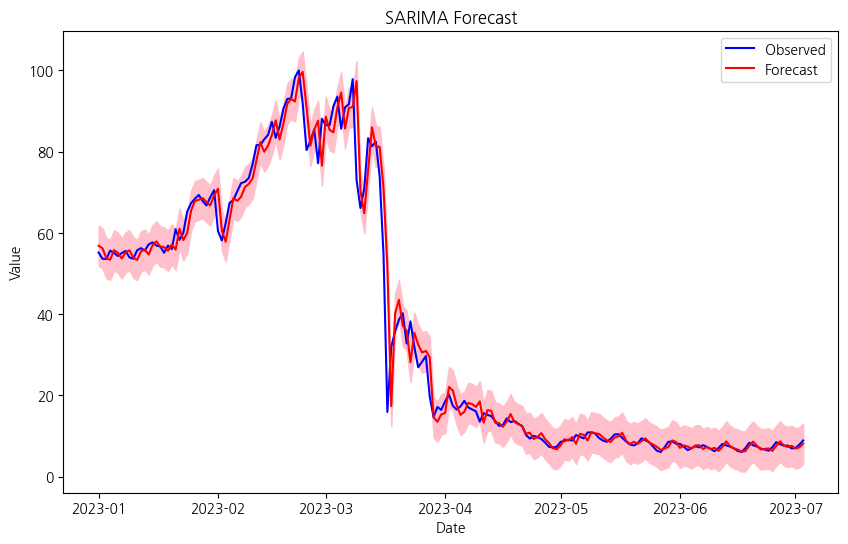

In [5]:
# Step 1: auto_arima를 사용하여 최적의 SARIMA 모델 찾기 (계절성 고려)
model_fit = auto_arima(ts, seasonal=True, m=12, suppress_warnings=True, stepwise=True)
order = model_fit.order
seasonal_order = model_fit.seasonal_order

# Step 2: 최적 모델로 SARIMAX 모델 구성
sarima_model = SARIMAX(ts, order=order, seasonal_order=seasonal_order)

# 모델 피팅
results = sarima_model.fit(disp=False)

# 1. get_prediction -> 구간을 설정하여 예측
# 2023-01-01부터 2023-07-03까지 예측
start_date = '2023-01-01'
end_date = '2023-07-03'
forecast = results.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)

# 예측값과 신뢰구간(lower, upper) 출력
# print(forecast.predicted_mean)
# print(forecast.conf_int())

# 결과 시각화
plt.figure(figsize=(10, 6))
# 슬라이싱하여 해당 기간의 원본 데이터만 플롯
ts_start_date = ts[start_date:]
# 원본 데이터 플롯
plt.plot(ts_start_date, label='Observed', color='blue')
# 예측값 플롯
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
# 신뢰구간 플롯
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower 디지털/가전'], forecast.conf_int()['upper 디지털/가전'], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [6]:
# 예측된 평균값들
predicted_mean_values = forecast.predicted_mean

# 실제 관측치 (ts)에서 해당 구간만 추출
# 여기서 start_date와 end_date는 해당 구간의 시작과 끝을 나타내는 변수입니다.
true_values = ts[start_date:end_date]

# Step 4: MSE (평균 제곱 오차) 계산
mse = mean_squared_error(true_values, predicted_mean_values)
print("Mean Squared Error (MSE):", mse)

# Step 5: RMSE (평균 제곱근 오차) 계산
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 21.905794227925675
Root Mean Squared Error (RMSE): 4.680362617140436


### 로그변환

In [7]:
timeSeries = df.loc[:, ['period', '디지털/가전']]
timeSeries.index = timeSeries.period
ts = timeSeries.drop('period', axis=1)

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


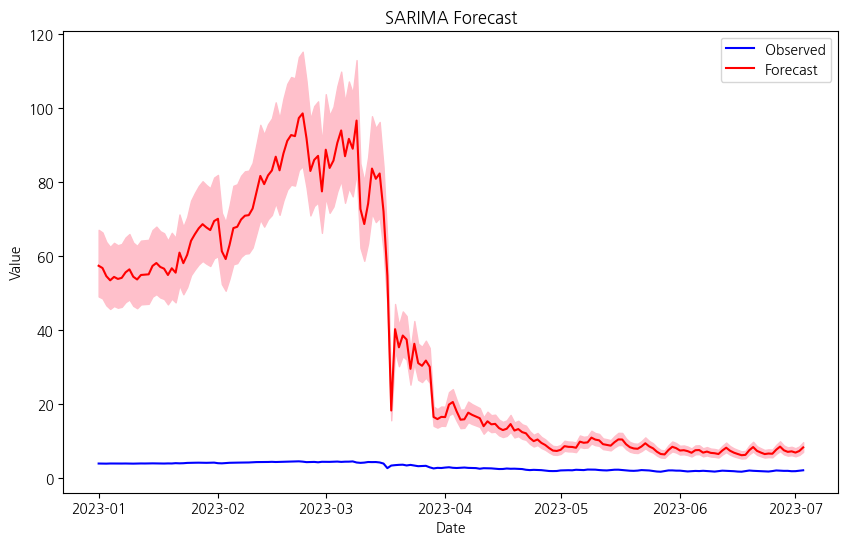

In [8]:
# '디지털/가전' 컬럼에 로그 변환을 적용합니다.
ts['디지털/가전'] = ts['디지털/가전'].apply(lambda x: np.log(x))

# Step 1: auto_arima를 사용하여 최적의 SARIMA 모델 찾기 (계절성 고려)
model_fit = auto_arima(ts, seasonal=True, m=12, suppress_warnings=True, stepwise=True)
order = model_fit.order
seasonal_order = model_fit.seasonal_order

# Step 2: 최적 모델로 SARIMAX 모델 구성
sarima_model = SARIMAX(ts, order=order, seasonal_order=seasonal_order)

# 모델 피팅
results = sarima_model.fit(disp=False)

# 1. get_prediction -> 구간을 설정하여 예측
# 2023-01-01부터 2023-07-03까지 예측
start_date = '2023-01-01'
end_date = '2023-07-03'
forecast = results.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)

# 로그 변환을 원래대로 되돌립니다.
forecast_predicted_mean = np.exp(forecast.predicted_mean)
forecast_conf_int = np.exp(forecast.conf_int())

# 결과 시각화
plt.figure(figsize=(10, 6))
# 슬라이싱하여 해당 기간의 원본 데이터만 플롯
ts_start_date = ts[start_date:]
# 원본 데이터 플롯
plt.plot(ts_start_date, label='Observed', color='blue')
# 예측값 플롯
plt.plot(forecast_predicted_mean, label='Forecast', color='red')
# 신뢰구간 플롯
plt.fill_between(forecast_conf_int.index, forecast_conf_int['lower 디지털/가전'], forecast_conf_int['upper 디지털/가전'], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [9]:
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  785
Model:             SARIMAX(4, 1, 2)x(1, 0, [], 12)   Log Likelihood                 868.693
Date:                             Sat, 22 Jul 2023   AIC                          -1721.386
Time:                                     17:53:41   BIC                          -1684.071
Sample:                                 05-10-2021   HQIC                         -1707.037
                                      - 07-03-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1312      0.030     37.878      0.000       1.073       1.190
ar.L2         -1.0261      

In [10]:
# 예측된 평균값들
predicted_mean_values = forecast.predicted_mean

# 실제 관측치 (ts)에서 해당 구간만 추출
# 여기서 start_date와 end_date는 해당 구간의 시작과 끝을 나타내는 변수입니다.
true_values = ts[start_date:end_date]

# Step 4: MSE (평균 제곱 오차) 계산
mse = mean_squared_error(true_values, predicted_mean_values)
print("Mean Squared Error (MSE):", mse)

# Step 5: RMSE (평균 제곱근 오차) 계산
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.016885854211153815
Root Mean Squared Error (RMSE): 0.12994558173002196
